# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# # 한글 폰트가 깨지면 실행하세요! 
# # 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
# import matplotlib.font_manager as fm
# fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# # 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
# fontlist[:]

# from matplotlib import font_manager, rc
# #font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
# font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "input/"

# original data : data 
data =  pd.read_csv(path + "demential_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date

**activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data


- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [5]:
# column의 수가 많기 때문에 효율적으로 관리하기 위해서 
# column의 이름들을 묶어서 진행합시다
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min', 
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']
convert_cols = data.iloc[:, 60:65].columns

In [6]:
# data -> processed_data 
# Drop Features 
processed_data = data.drop(drop_cols, axis=1).copy()
processed_data = processed_data.drop(convert_cols, axis=1).copy()
processed_data

,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,2020-11-27,1.71875,730,2944,14346,0,417,0,545,47,...,62,100,41,50,27,97,66,62,-0.12,CN
1,2020-11-28,1.40625,342,2449,6352,0,473,0,392,8,...,54,100,49,43,46,91,35,44,-0.32,CN
2,2020-11-29,1.46875,401,2544,7297,0,586,0,362,24,...,61,100,56,47,34,89,41,62,0.07,CN
3,2020-11-30,0.34375,27,1850,491,0,176,0,34,1,...,55,100,35,40,44,86,29,56,-0.41,CN
4,2020-12-01,1.46875,333,2518,5861,0,646,0,377,6,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2020-12-22,1.34375,227,2316,3863,3,735,2,155,17,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,2020-12-24,1.34375,249,2351,4411,1,780,4,167,22,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,2020-12-26,1.53125,570,2682,11057,1,518,1,332,61,...,65,100,1,56,69,86,89,64,0.41,CN
9325,2020-12-27,1.34375,295,2331,5135,4,578,0,173,30,...,81,100,9,59,86,89,98,97,0.27,CN


In [7]:
processed_data = processed_data.drop('summary_date', axis=1).copy()
processed_data

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,730,2944,14346,0,417,0,545,47,0,...,62,100,41,50,27,97,66,62,-0.12,CN
1,1.40625,342,2449,6352,0,473,0,392,8,0,...,54,100,49,43,46,91,35,44,-0.32,CN
2,1.46875,401,2544,7297,0,586,0,362,24,0,...,61,100,56,47,34,89,41,62,0.07,CN
3,0.34375,27,1850,491,0,176,0,34,1,0,...,55,100,35,40,44,86,29,56,-0.41,CN
4,1.46875,333,2518,5861,0,646,0,377,6,0,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.34375,227,2316,3863,3,735,2,155,17,21,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,1.34375,249,2351,4411,1,780,4,167,22,7,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,1.53125,570,2682,11057,1,518,1,332,61,7,...,65,100,1,56,69,86,89,64,0.41,CN
9325,1.34375,295,2331,5135,4,578,0,173,30,28,...,81,100,9,59,86,89,98,97,0.27,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [8]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# processed_data -> input_data 
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [9]:
# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [10]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 5. Modeling - ML

- Linear model
    - Logistic Linear Regression 
- Tree model 
    - RandomForest 
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [11]:
#!pip install xgboost

In [12]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_rf = RandomForestClassifier()

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )
model_lgbm = LGBMClassifier()

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4843,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6743,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5583,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5489,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5389,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.56094


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.53868


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5349,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5436,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5295,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5460800000000001


In [16]:
pred_rf = model_rf.predict(test_X)

pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

# 6. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [17]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [18]:
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1194
           1       0.92      0.84      0.87       129
           2       0.92      0.71      0.80       543

    accuracy                           0.88      1866
   macro avg       0.90      0.84      0.86      1866
weighted avg       0.89      0.88      0.88      1866



In [19]:
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



In [20]:
print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.86      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:>

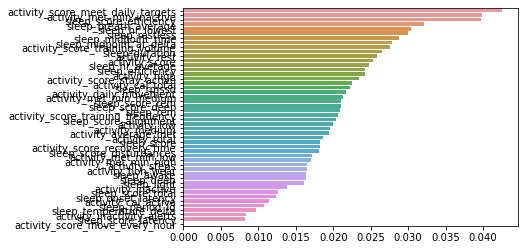

In [21]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=tr_val_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

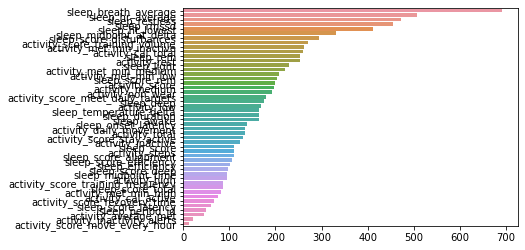

In [22]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=tr_val_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

In [23]:
#!pip install tensorflow

In [24]:
import math
import sklearn
import sklearn.preprocessing
import datetime
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

Instructions for updating:
non-resource variables are not supported in the long term
C:\Users\bhs89\machine-learning: ['.ipynb_checkpoints', 'cache', 'datasets_for_clustering', 'dataset_for_clustering.ipynb', 'Machine_learning', 'Team_project']
C:\Users\bhs89\machine-learning\Team_project: ['-p', '.ipynb_checkpoints', 'baseline_hong-Copy1.ipynb', 'baseline_hong.ipynb', 'Dementia_df_hong.ipynb', 'EDA_report_code_dementia.ipynb', 'input', 'RNN', 'saved_model']


In [25]:
cols_convert = data.columns[60:66]
data_convert = data[cols_convert].copy()
data_convert

,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...
9322,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


In [26]:
signal_list = list(data_convert['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
signal_df1 = pd.DataFrame(signal_list).drop(288, axis=1).astype('float')
y_df = data_convert['DIAG_NM']
signal_df1 = pd.concat([signal_df1, y_df], axis=1)
signal_df1

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,DIAG_NM
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9323,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9324,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9325,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN


In [27]:
df_stock_norm = processed_data.copy()

In [28]:
df_stock_norm.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,730,2944,14346,0,417,0,545,47,0,...,62,100,41,50,27,97,66,62,-0.12,CN
1,1.40625,342,2449,6352,0,473,0,392,8,0,...,54,100,49,43,46,91,35,44,-0.32,CN
2,1.46875,401,2544,7297,0,586,0,362,24,0,...,61,100,56,47,34,89,41,62,0.07,CN
3,0.34375,27,1850,491,0,176,0,34,1,0,...,55,100,35,40,44,86,29,56,-0.41,CN
4,1.46875,333,2518,5861,0,646,0,377,6,0,...,56,100,64,55,39,14,54,59,-0.27,CN


#### CONVERT(activity_met_1min USING utf8) 에 대해 RNN 모델로 예측해봄.

148명에 대한 데일리 라이프로그 데이터 크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다.  
- 내가 원하는거는 DIAN_NM에 따른 activity_met_1min 패턴 예측
- 이로써 얻을 수 있는 것 : 정상과 비교하여 주로 환자들이 띄는 경향성 파악
- 좀 더 디테일한 비교를 원한다면 여러 convert데이터에 대해 동시 비교진행

In [29]:
signal_list = list(data_convert['CONVERT(activity_met_1min USING utf8)'].str.split('/'))
signal_df2 = pd.DataFrame(signal_list).drop(1440, axis=1).astype('float')

In [30]:
signal_df2

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.9,0.9,1.4,1.9,1.1,0.9,0.9,1.1,1.3,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,1.1,1.1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.1,1.4,1.2,0.9,1.2,1.1,0.9,0.9,0.9,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9323,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9324,0.9,0.9,0.9,0.9,1.1,0.9,0.9,1.1,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9325,1.1,0.9,0.9,0.9,1.0,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [31]:
signal_df2 = pd.concat([signal_df2, y_df], axis=1)

In [32]:
signal_df2_group = signal_df2.groupby('DIAG_NM')
#signal_df2_group = signal_df2_group.mean()
signal_df2_group = signal_df2_group.mean().transpose()
signal_df2_group

# # 3개 끊어서 평균 찍어보려고 나눠봤습니다 
# # 앞에서부터 3 토막 나눴습니다
# #signal_df2['mean_1'] = signal_df2.iloc[:, :3109].mean(axis=1)
# #signal_df2['mean_2'] = signal_df2.iloc[:, 3109:6218].mean(axis=1)
# #signal_df2['mean_3'] = signal_df2.iloc[:, 6218:9327].mean(axis=1)

# signal_df2_group.head()

DIAG_NM,CN,Dem,MCI
0,1.074652,1.055763,1.112887
1,1.001357,1.007788,1.029566
2,0.998576,0.993769,1.019735
3,0.990836,0.978349,1.018741
4,0.992495,0.991745,1.027651
...,...,...,...
1435,0.941263,0.938629,0.962482
1436,0.931329,0.935358,0.948748
1437,0.920791,0.932710,0.937408
1438,0.907271,0.913551,0.923601


**y variable**
- DIAG_NM 
    - 정상(CN), 치매(Dem), 경도인지 장애(MCI)

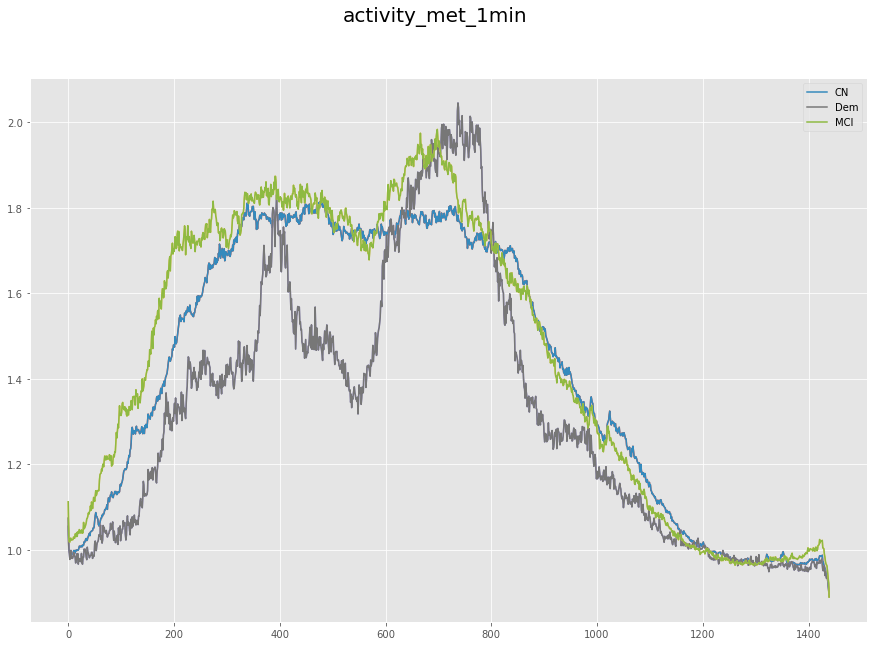

In [33]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.suptitle("activity_met_1min", fontsize=20)

cols = signal_df2_group.columns
for i in range(3):
    plt.plot(signal_df2_group[cols[i]])
    plt.plot(signal_df2_group[cols[i]], label = str(cols[i]))
plt.legend()
plt.show()

In [34]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

CONVERT(activity_met_1min USING utf8) 에 대해 RNN 모델로 예측해봄.
- signal_df2_group

In [35]:
activity_met_1min_CN = pd.DataFrame(signal_df2_group["CN"])
activity_met_1min_CN = activity_met_1min_CN.transpose()
activity_met_1min_CN

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
CN,1.074652,1.001357,0.998576,0.990836,0.992495,0.997152,0.993701,0.989747,0.990987,0.991623,...,0.956006,0.958335,0.955135,0.945468,0.944379,0.941263,0.931329,0.920791,0.907271,0.891623


In [36]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(activity_met_1min_CN, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
# # function to get the next batch
# def get_next_batch(batch_size):
#     global index_in_epoch, x_train, perm_array   
#     start = index_in_epoch
#     index_in_epoch += batch_size

#     if index_in_epoch > x_train.shape[0]:
#         np.random.shuffle(perm_array) # shuffle permutation array
#         start = 0 # start next epoch
#         index_in_epoch = batch_size

#     end = index_in_epoch
#     return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [ ]:
# def RNN_model(n_steps, 
#     n_inputs = 3, 
#     n_neurons = 200, 
#     n_outputs = 3,
#     n_layers = 2,
#     learning_rate = 0.001,
#     batch_size = 1,
#     n_epochs = 100,
#     train_set_size = x_train.shape[0],
#     test_set_size = x_test.shape[0]):
#     seq_len = 20 # choose sequence length
#     x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(signal_df2_group, seq_len)
#     print('x_train.shape = ',x_train.shape)
#     print('y_train.shape = ', y_train.shape)
#     print('x_valid.shape = ',x_valid.shape)
#     print('y_valid.shape = ', y_valid.shape)
#     print('x_test.shape = ', x_test.shape)
#     print('y_test.shape = ',y_test.shape)
    
#     # from tensorflow.python.framework import ops
#     # ops.reset_default_graph()
#     # import tensorflow.compat.v1 as tf
#     # tf_.disable_v2_behavior()
#     tf.set_random_seed(2022)

#     ## Basic Cell RNN in tensorflow

#     index_in_epoch = 0;
#     perm_array  = np.arange(x_train.shape[0])
#     np.random.shuffle(perm_array)
    
#     #tf.reset_default_graph()
#     X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
#     y = tf.placeholder(tf.float32, [None, n_outputs])
    
#     # use Basic RNN Cell
#     # layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#     #           for layer in range(n_layers)]
#     layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#               for layer in range(n_layers)]
#     # layers =tf.keras.layers.SimpleRNNCell(units=n_neurons) #n_neurons= 출력의 크기

#     # use Basic LSTM Cell 
#     # layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#     #          for layer in range(n_layers)]

#     # use LSTM Cell with peephole connections
#     # layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
#     #                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#     #          for layer in range(n_layers)]

#     # use GRU cell
#     #layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#     #          for layer in range(n_layers)]

#     multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)
#     rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

#     stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
#     stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
#     outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
#     outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

#     loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
#     training_op = optimizer.minimize(loss)
    
#     # run graph
#     with tf.Session() as sess: 
#         sess.run(tf.global_variables_initializer())
#         for iteration in range(int(n_epochs*train_set_size/batch_size)):
#             x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
#             sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
#             if iteration % int(5*train_set_size/batch_size) == 0:
#                 mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
#                 mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
#                 print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
#                     iteration*batch_size/train_set_size, mse_train, mse_valid))

#         y_train_pred = sess.run(outputs, feed_dict={X: x_train})
#         y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
#         y_test_pred = sess.run(outputs, feed_dict={X: x_test})


In [ ]:
# tf.set_random_seed(2022)

# ## Basic Cell RNN in tensorflow

# index_in_epoch = 0;
# perm_array  = np.arange(x_train.shape[0])
# np.random.shuffle(perm_array)

# RNN_model = RNN_model(n_steps = seq_len -1, 
#     n_inputs = 3, 
#     n_neurons = 200, 
#     n_outputs = 3,
#     n_layers = 2,
#     learning_rate = 0.001,
#     batch_size = 1,
#     n_epochs = 100,
#     train_set_size = x_train.shape[0],
#     test_set_size = x_test.shape[0])

In [ ]:
# from tensorflow.python.framework import ops
# ops.reset_default_graph()
# import tensorflow.compat.v1 as tf
# tf_.disable_v2_behavior()

#tf.random.set_seed(2022)
tf.set_random_seed(2022)

## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 3 
n_neurons = 200 
n_outputs = 3
n_layers = 2
learning_rate = 0.001
batch_size = 1
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

In [ ]:
#tf.reset_default_graph()

# X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [ ]:
# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
# layers =tf.keras.layers.SimpleRNNCell(units=n_neurons) #n_neurons= 출력의 크기

# use Basic LSTM Cell 
# layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
# layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)

In [ ]:
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [ ]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [ ]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

In [ ]:
y_train.shape

In [ ]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('Existing data activity_met_1min USING utf8')
plt.xlabel('activity_met_1min USING utf8')
plt.ylabel('acitvity_amout')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('Prediction of activity_met_1min USING utf8')
plt.xlabel('activity_met_1min USING utf8')
plt.ylabel('acitvity_amout')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

In [ ]:
tf.reset_default_graph()